In [65]:
import sys
sys.path.insert(0, './src/yelp_prediction')

In [66]:
import polars as pl
import dataframes as df
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [67]:
(df_businesses, df_exact_stars, df_photos_per_business, df_photos) = pl.collect_all(
    (
        df.q_businesses,
        df.q_exact_stars,
        df.q_photos_agg,
        df.q_photos
    )
)

In [68]:
predictions = pl.read_csv("data/predictions.csv")
display(predictions)

epoch,photo_id,prediction
i64,str,f64
1,"""ku7dDalUBxMq9hNs_Wfbdw""",4.050697
1,"""2PEsJGoi64QdE4Q84tuQlw""",3.96728
1,"""9lozNYUpkUfcAYsfvUaiCg""",4.081518
1,"""47bDOXOfuSanXzb9cf-bwg""",3.860026
1,"""YQhN0cE3kP0TVrSqfgmpAg""",3.955819
…,…,…
20,"""m-ZG1wWsyD_lgYjF-T13zQ""",4.009113
20,"""C60JSUAYjNUfa_9xCvTbvQ""",3.894257
20,"""wsYH-pY9Go4nqD3lsDxVMw""",4.126926


In [69]:
table = (
    df_photos.join(predictions, on="photo_id")
    .join(df_exact_stars, on="business_id")
    .join(df_businesses, on="business_id")
    .join(df_photos_per_business, on="business_id")
    .select(
        pl.col("epoch"),
        pl.col("photo_id"),
        pl.col("business_id"),
        pl.col("photo_count").alias("business_photo_count"),
        pl.col("label"),
        pl.col("review_count").alias("business_review_count"),
        pl.col("prediction"),
        pl.col("exact_stars").alias("actual"),
    )
    .with_columns(
        (pl.col("prediction") - pl.col("actual")).alias("error"),
    )
    .with_columns(
        pl.col("error").abs().alias("abs_error"),
    )
)

display(table)

epoch,photo_id,business_id,business_photo_count,label,business_review_count,prediction,actual,error,abs_error
i64,str,str,u32,str,i64,f64,f64,f64,f64
1,"""ku7dDalUBxMq9hNs_Wfbdw""","""MK0OMY_u9unl8xSqjPLtMw""",15,"""food""",661,4.050697,4.391176,-0.340479,0.340479
1,"""2PEsJGoi64QdE4Q84tuQlw""","""MK0OMY_u9unl8xSqjPLtMw""",15,"""food""",661,3.96728,4.391176,-0.423896,0.423896
1,"""9lozNYUpkUfcAYsfvUaiCg""","""MK0OMY_u9unl8xSqjPLtMw""",15,"""menu""",661,4.081518,4.391176,-0.309658,0.309658
1,"""47bDOXOfuSanXzb9cf-bwg""","""MK0OMY_u9unl8xSqjPLtMw""",15,"""food""",661,3.860026,4.391176,-0.531151,0.531151
1,"""YQhN0cE3kP0TVrSqfgmpAg""","""MK0OMY_u9unl8xSqjPLtMw""",15,"""food""",661,3.955819,4.391176,-0.435357,0.435357
…,…,…,…,…,…,…,…,…,…
20,"""m-ZG1wWsyD_lgYjF-T13zQ""","""TlvnDLrM4p2udHfeUwL82A""",19,"""inside""",544,4.009113,4.357639,-0.348526,0.348526
20,"""C60JSUAYjNUfa_9xCvTbvQ""","""TlvnDLrM4p2udHfeUwL82A""",19,"""food""",544,3.894257,4.357639,-0.463382,0.463382
20,"""wsYH-pY9Go4nqD3lsDxVMw""","""TlvnDLrM4p2udHfeUwL82A""",19,"""food""",544,4.126926,4.357639,-0.230712,0.230712


In [70]:
table_by_epoch = (
    table.group_by("epoch")
    .agg(
        pl.col("abs_error").mean().alias("mae"),
        pl.col("error").pow(2).mean().alias("mse"),
    )
    .with_columns(
        pl.col("mse").sqrt().alias("rmse"),
    )
    .sort("epoch")
)

display(table_by_epoch)


epoch,mae,mse,rmse
i64,f64,f64,f64
1,0.385752,0.253026,0.503017
2,0.381907,0.247614,0.497608
3,0.382066,0.248154,0.49815
4,0.377725,0.240132,0.490033
5,0.37657,0.241667,0.491597
…,…,…,…
16,0.377277,0.239605,0.489494
17,0.375675,0.242751,0.492698
18,0.379198,0.242329,0.492269


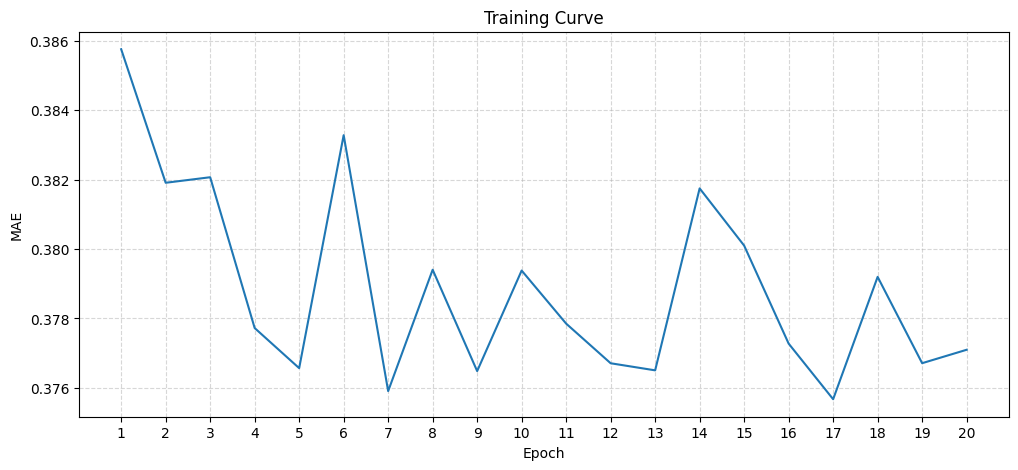

In [71]:
plt.figure(figsize=(12, 5))
plt.plot(
    table_by_epoch["epoch"],
    table_by_epoch["mae"],
)
plt.title("Training Curve")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.xticks(range(1, 21))
plt.grid(True, which="both", ls="--", alpha=0.5)

In [72]:
def _get_best_table_by(col: str):
    best_epoch = table_by_epoch.sort(by=col).slice(0, 1).select("epoch").item()
    best_epoch_table = table.filter(pl.col("epoch") == best_epoch).drop("epoch")
    return best_epoch, best_epoch_table


best_epoch, best_epoch_table = _get_best_table_by("mae")
display(best_epoch_table)

photo_id,business_id,business_photo_count,label,business_review_count,prediction,actual,error,abs_error
str,str,u32,str,i64,f64,f64,f64,f64
"""ku7dDalUBxMq9hNs_Wfbdw""","""MK0OMY_u9unl8xSqjPLtMw""",15,"""food""",661,4.089602,4.391176,-0.301574,0.301574
"""2PEsJGoi64QdE4Q84tuQlw""","""MK0OMY_u9unl8xSqjPLtMw""",15,"""food""",661,4.205267,4.391176,-0.18591,0.18591
"""9lozNYUpkUfcAYsfvUaiCg""","""MK0OMY_u9unl8xSqjPLtMw""",15,"""menu""",661,4.160651,4.391176,-0.230526,0.230526
"""47bDOXOfuSanXzb9cf-bwg""","""MK0OMY_u9unl8xSqjPLtMw""",15,"""food""",661,3.747412,4.391176,-0.643765,0.643765
"""YQhN0cE3kP0TVrSqfgmpAg""","""MK0OMY_u9unl8xSqjPLtMw""",15,"""food""",661,3.894899,4.391176,-0.496277,0.496277
…,…,…,…,…,…,…,…,…
"""m-ZG1wWsyD_lgYjF-T13zQ""","""TlvnDLrM4p2udHfeUwL82A""",19,"""inside""",544,4.003858,4.357639,-0.353781,0.353781
"""C60JSUAYjNUfa_9xCvTbvQ""","""TlvnDLrM4p2udHfeUwL82A""",19,"""food""",544,4.023864,4.357639,-0.333775,0.333775
"""wsYH-pY9Go4nqD3lsDxVMw""","""TlvnDLrM4p2udHfeUwL82A""",19,"""food""",544,3.985162,4.357639,-0.372477,0.372477


In [73]:
best_epoch_table_grouped = best_epoch_table.group_by("business_id").agg(
    abs_error=pl.col("abs_error").mean(),
    actual=pl.col("actual").first(),
)

print("grouped MAE:", best_epoch_table_grouped["abs_error"].mean())

best_epoch_table_grouped

grouped MAE: 0.4443188729713613


business_id,abs_error,actual
str,f64,f64
"""n-kphRn0ts4CBIMQCO7UpA""",0.237488,3.443609
"""8OxOLZdINv7OtcZDDAsRCA""",0.637135,4.88
"""575inWPYxLk4YzwWqRhexw""",0.252524,3.766055
"""e1jylvnhcMVr1ER8PO4dpA""",0.259407,4.180851
"""9Wor6FL3k1Ce5cVSUcnbxA""",0.291621,4.111111
…,…,…
"""MjRKDyS3qvog5kwIk7pubA""",0.439231,3.607143
"""EUu9FqaXxIwhRxLgEJ6WiQ""",0.103072,2.806818
"""T0GS1FEYQBy2xlxWGWamBw""",0.110585,3.984375


macro-averaged MAE: 0.60


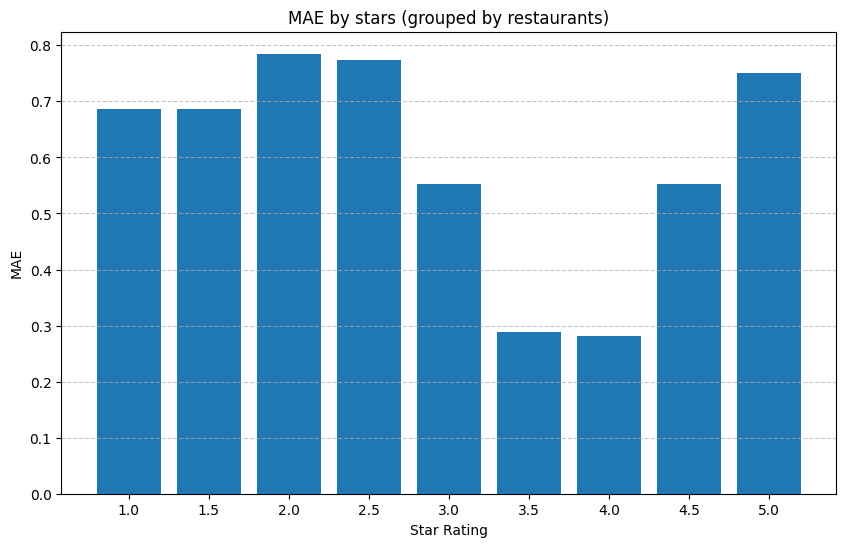

In [74]:
step_size = 0.5
floored_stars_q = (pl.col("actual") / step_size).floor() * step_size
grouped = (
    best_epoch_table_grouped.group_by(floored_stars_q.alias("stars"))
    .agg(
        pl.col("abs_error").mean().alias("mae"),
        pl.col("abs_error").pow(2).mean().alias("mse"),
    )
    .sort("stars")
)

print(f"macro-averaged MAE: {grouped["mae"].mean():.2f}")

plt.figure(figsize=(10, 6))
plt.bar(
    x=grouped["stars"],
    height=grouped["mae"],
    width=0.4,
)
plt.title("MAE by stars (grouped by restaurants)")
plt.xlabel("Star Rating")
plt.ylabel("MAE")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks([x/2+1 for x in range(9)]);

macro-averaged MAE: 0.58


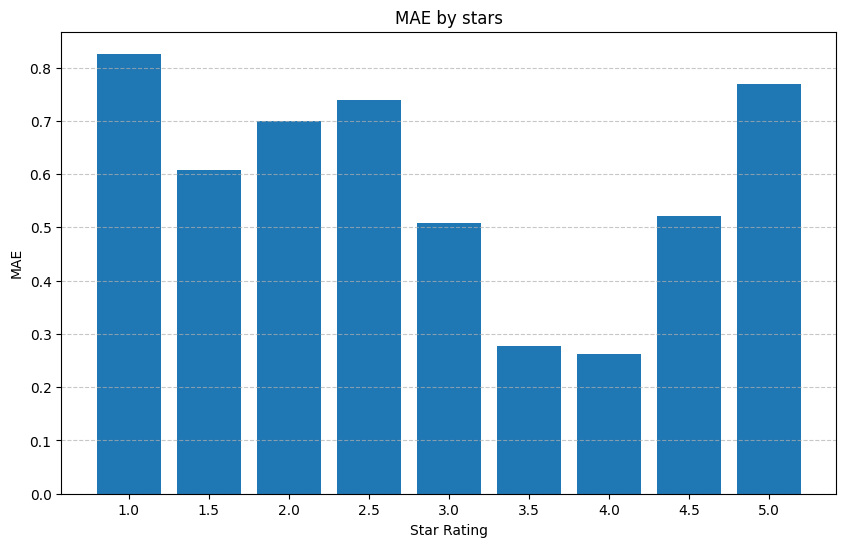

In [75]:
step_size = 0.5
floored_stars_q = (pl.col("actual") / step_size).floor() * step_size
grouped = (
    best_epoch_table.group_by(floored_stars_q.alias("stars"))
    .agg(
        pl.col("abs_error").mean().alias("mae"),
        pl.col("error").pow(2).mean().alias("mse"),
    )
    .sort("stars")
)

print(f"macro-averaged MAE: {grouped["mae"].mean():.2f}")

plt.figure(figsize=(10, 6))
plt.bar(
    x=grouped["stars"],
    height=grouped["mae"],
    width=0.4,
)
plt.title("MAE by stars")
plt.xlabel("Star Rating")
plt.ylabel("MAE")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks([x/2+1 for x in range(9)]);

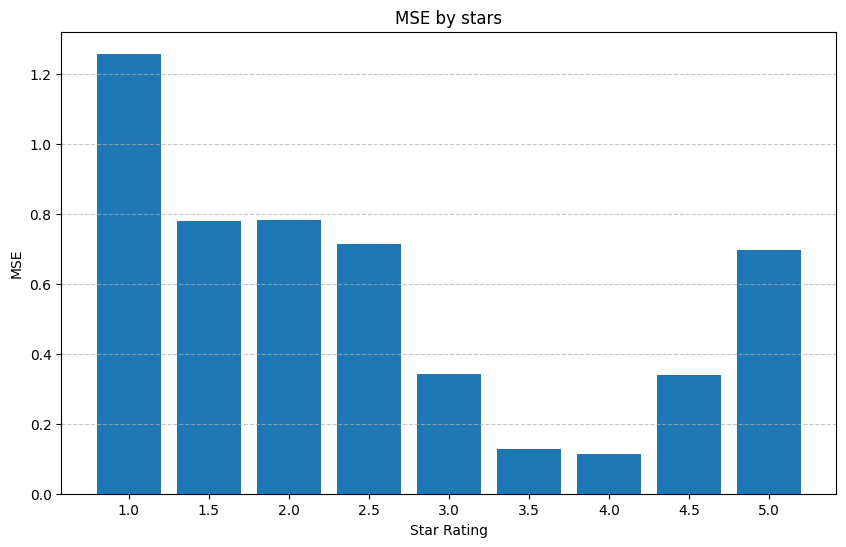

In [76]:
plt.figure(figsize=(10, 6))
plt.bar(
    x=grouped["stars"],
    height=grouped["mse"],
    width=0.4,
)
plt.title("MSE by stars")
plt.xlabel("Star Rating")
plt.ylabel("MSE")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks([x/2+1 for x in range(9)]);

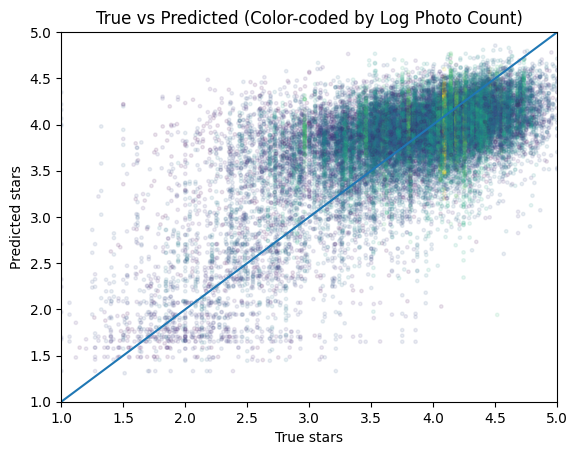

In [77]:
plt.figure()
plt.scatter(
    x=best_epoch_table["actual"],
    y=best_epoch_table["prediction"],
    c=best_epoch_table["business_photo_count"],
    norm=colors.LogNorm(
        vmin=best_epoch_table["business_photo_count"].min(), # type: ignore
        vmax=best_epoch_table["business_photo_count"].max(), # type: ignore
    ),
    cmap='viridis',
    s=6,
    alpha=0.1,
)
plt.plot([1, 5], [1, 5])
plt.xlim(1, 5)
plt.ylim(1, 5)
plt.xlabel("True stars")
plt.ylabel("Predicted stars")
plt.title("True vs Predicted (Color-coded by Log Photo Count)")

None

In [78]:
aggr_by_business = best_epoch_table.group_by("business_id").agg(
    pl.col("abs_error").mean(),
    pl.col("business_photo_count").first(),
    pl.col("business_review_count").first(),
)

aggr_by_business

business_id,abs_error,business_photo_count,business_review_count
str,f64,u32,i64
"""UWQNx6qZojXlDv1kBAMHug""",0.119929,2,123
"""rZkwiLIUO50ozobE0sVp3A""",0.896635,2,47
"""7qq5LfBZj6F4lXnLAQUdKg""",0.048144,2,61
"""ZXRdFOGhlkmLgjj-Mkupuw""",0.114645,1,17
"""fmoUsX3lNoJM3GU1elS2ig""",0.786957,1,17
…,…,…,…
"""1wy8va7aZ7eXXCIVGajYhw""",0.874164,7,25
"""FCCnOgjjvwQJBAy3u2fcLA""",0.336374,11,269
"""EEG49pRkK7e8OVX28RIr_w""",0.050922,1,32


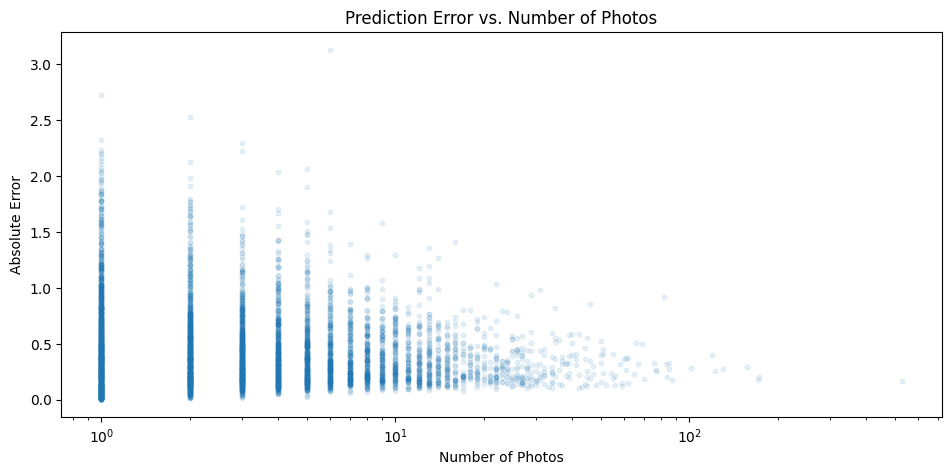

In [79]:
plt.figure(figsize=(25, 5))
plt.subplot(1, 2, 1)
plt.scatter(
    x=aggr_by_business["business_photo_count"],
    y=aggr_by_business["abs_error"],
    alpha=0.1,
    s=10,
)
plt.title("Prediction Error vs. Number of Photos")
plt.xlabel("Number of Photos")
plt.ylabel("Absolute Error")
plt.xscale("log")

None

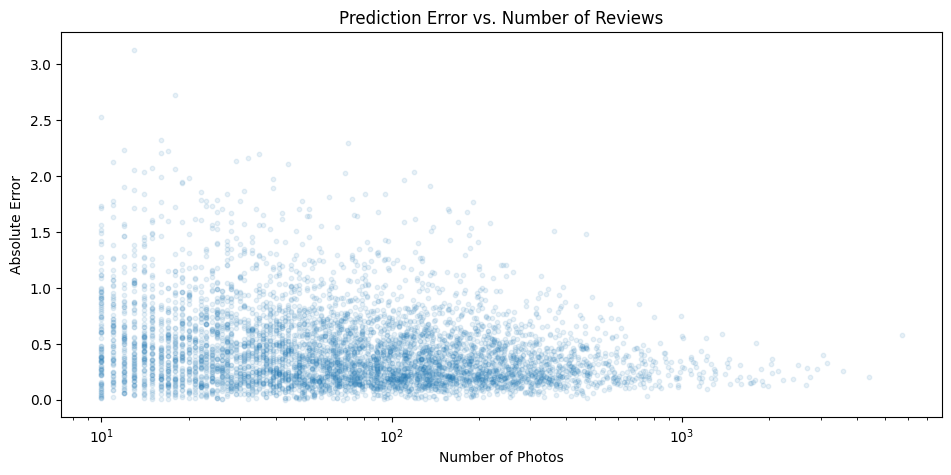

In [80]:
plt.figure(figsize=(25, 5))
plt.subplot(1, 2, 1)
plt.scatter(
    x=aggr_by_business["business_review_count"],
    y=aggr_by_business["abs_error"],
    alpha=0.1,
    s=10,
)
plt.title("Prediction Error vs. Number of Reviews")
plt.xlabel("Number of Photos")
plt.ylabel("Absolute Error")
plt.xscale("log")
None